
### Toy Transformer for CONTEXTUAL change detection (order + context matter)

What you get:
1) Synthetic dataset: time-series with/without a regime change in the 2nd half
2) Tiny attention-based Transformer-like block (single-head self-attention)
3) Training + test evaluation
4) Diagnostic plots that show "context understanding":
   - Example signals (change vs no-change)
   - Attention heatmaps (change vs no-change)
   - Attention "late->early" mass metric (should be higher for change samples)
   - Counterfactual test: shuffle time order (performance drops)

Run:
  python change_attention_demo.py
or paste into a notebook and run cell-by-cell.

We use small data and settings so it runs fast.


Device: cpu

Training...
Epoch 01 | train loss 0.4452 | test acc 0.986 (loss 0.1297) | SHUFFLED-time acc 0.981 (loss 0.1418)
Epoch 02 | train loss 0.0511 | test acc 1.000 (loss 0.0121) | SHUFFLED-time acc 0.999 (loss 0.0276)
Epoch 03 | train loss 0.0096 | test acc 1.000 (loss 0.0036) | SHUFFLED-time acc 1.000 (loss 0.0186)
Epoch 04 | train loss 0.0045 | test acc 1.000 (loss 0.0016) | SHUFFLED-time acc 0.998 (loss 0.0269)
Epoch 05 | train loss 0.0023 | test acc 1.000 (loss 0.0007) | SHUFFLED-time acc 0.885 (loss 0.2481)
Epoch 06 | train loss 0.0012 | test acc 1.000 (loss 0.0004) | SHUFFLED-time acc 0.840 (loss 0.3005)


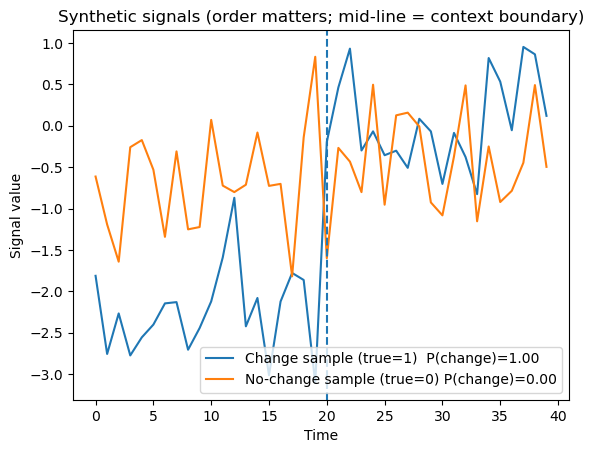

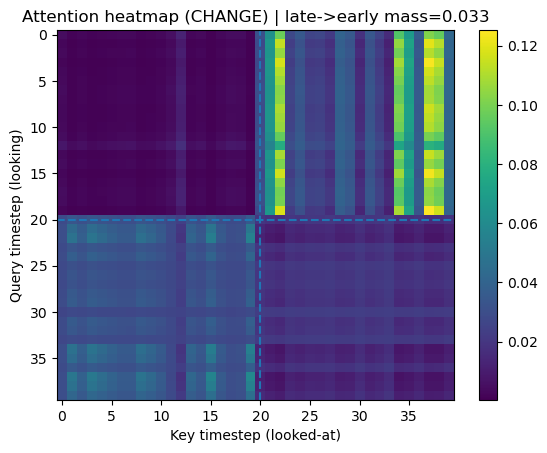

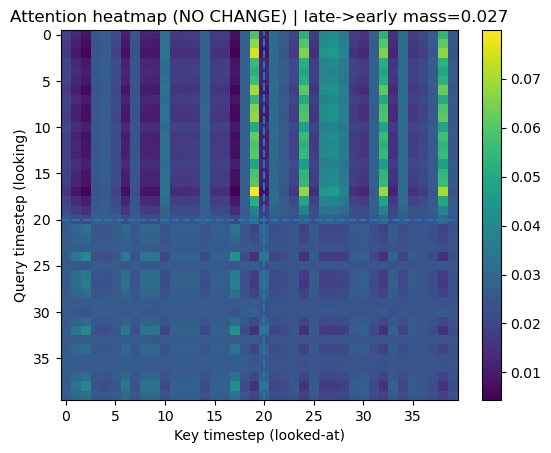

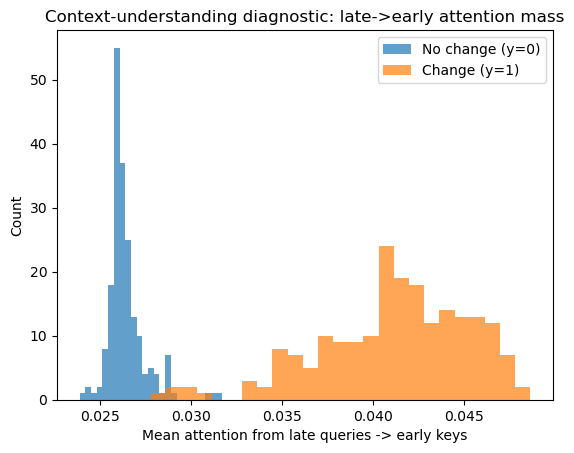

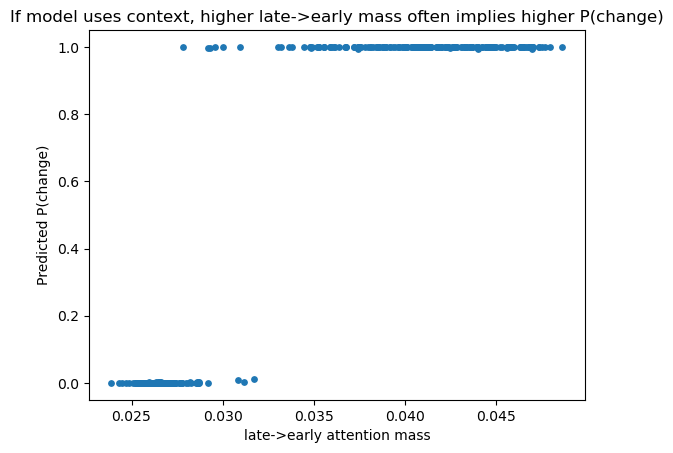


Key diagnostic numbers (example samples):
  CHANGE sample:    P(change)=1.000, late->early mass=0.033
  NO-CHANGE sample: P(change)=0.002, late->early mass=0.027

Interpretation:
  - If the model understands context, the CHANGE attention map tends to show stronger late->early focus,
    and the late->early mass histogram should be shifted higher for y=1 than y=0.
  - The SHUFFLED-time accuracy printed during training should drop notably, showing order matters.


In [ ]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


# -----------------------------
# We ensurereproducibility
# -----------------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# -----------------------------
# Synthetic change-detection dataset we generate
# -----------------------------
class ChangeDetectionDataset(Dataset):
    """
    Each sample is a length-T sequence x(t).
    Class 0 (no change): x(t)=mu + noise
    Class 1 (change):    first half mu + noise, second half (mu+delta)+noise

    We keep the absolute level mu random so the model must use CONTEXT,
    not absolute magnitude.
    """
    def __init__(self, n_samples=2000, T=40, sigma=0.5, delta=2.0, p_change=0.5, seed=123):
        super().__init__()
        g = torch.Generator().manual_seed(seed)

        self.T = T
        X = torch.zeros(n_samples, T, 1)
        y = torch.zeros(n_samples, dtype=torch.long)

        for i in range(n_samples):
            mu = torch.randn(1, generator=g).item() * 1.0  # random baseline
            change = (torch.rand(1, generator=g).item() < p_change)

            if not change:
                x = mu + sigma * torch.randn(T, generator=g)
                y[i] = 0
            else:
                x1 = mu + sigma * torch.randn(T // 2, generator=g)
                x2 = (mu + delta) + sigma * torch.randn(T - T // 2, generator=g)
                x = torch.cat([x1, x2], dim=0)
                y[i] = 1

            X[i, :, 0] = x

        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -----------------------------
# Single-head scaled dot-product self-attention
# -----------------------------
class ToySelfAttention(nn.Module):
    """
    x: (B, T, d_model)
    returns:
      out: (B, T, d_model)
      A:   (B, T, T) attention weights (row = query, col = key)
    """
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(Q.size(-1))  # (B,T,T)
        A = F.softmax(scores, dim=-1)
        out = A @ V
        return out, A


# -----------------------------
# Tiny Transformer block (Attn + residual + LN + FFN + residual + LN)
# -----------------------------
class TinyTransformerBlock(nn.Module):
    def __init__(self, d_model=32, d_ff=64, dropout=0.1):
        super().__init__()
        self.attn = ToySelfAttention(d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, A = self.attn(x)
        x = self.ln1(x + self.drop(attn_out))
        ffn_out = self.ffn(x)
        x = self.ln2(x + self.drop(ffn_out))
        return x, A


# -----------------------------
# End-to-end change detector
# -----------------------------
class AttentionChangeDetector(nn.Module):
    """
    Inputs: (B, T, 1)
    Output: logits (B,2)
    Also returns attention matrix A (B,T,T) for diagnostics
    """
    def __init__(self, T=40, d_model=32, d_ff=64, dropout=0.1):
        super().__init__()
        self.T = T
        self.proj = nn.Linear(1, d_model)
        self.pos = nn.Parameter(torch.zeros(1, T, d_model))  # learned positional embedding
        self.block = TinyTransformerBlock(d_model=d_model, d_ff=d_ff, dropout=dropout)
        self.cls = nn.Linear(d_model, 2)

        # init pos small
        nn.init.normal_(self.pos, mean=0.0, std=0.02)

    def forward(self, x, return_attn=False):
        B, T, C = x.shape
        assert T == self.T and C == 1
        h = self.proj(x) + self.pos          # (B,T,d_model)
        h, A = self.block(h)                 # (B,T,d_model), (B,T,T)
        pooled = h.mean(dim=1)               # (B,d_model)
        logits = self.cls(pooled)            # (B,2)
        if return_attn:
            return logits, A
        return logits


# -----------------------------
# Helpers
# -----------------------------
@torch.no_grad()
def evaluate(model, loader, device="cpu", shuffle_time=False):
    model.eval()
    total, correct = 0, 0
    total_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if shuffle_time:
            # counterfactual: destroy order (same values, wrong order)
            idx = torch.randperm(x.size(1), device=device)
            x = x[:, idx, :]

        logits = model(x)
        loss = F.cross_entropy(logits, y)
        pred = logits.argmax(dim=-1)

        total += y.numel()
        correct += (pred == y).sum().item()
        total_loss += loss.item() * y.size(0)

    return total_loss / total, correct / total


def attention_late_to_early_mass(A):
    """
    A: (T,T) attention for ONE sample
    We measure how much attention queries in the LATE half put on keys in the EARLY half.
    This is a clean "context comparison" diagnostic.

    returns scalar in [0,1]
    """
    T = A.shape[0]
    mid = T // 2
    late_queries = slice(mid, T)
    early_keys = slice(0, mid)
    return A[late_queries, early_keys].mean()


def pick_example_indices(dataset, n_change=1, n_nochange=1, seed=0):
    rng = np.random.default_rng(seed)
    y = dataset.y.numpy()
    idx_change = rng.choice(np.where(y == 1)[0], size=n_change, replace=False).tolist()
    idx_no = rng.choice(np.where(y == 0)[0], size=n_nochange, replace=False).tolist()
    return idx_change, idx_no


# -----------------------------
# Main demo
# -----------------------------
def main():
    seed_everything(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    # Small-ish settings so it runs quickly
    T = 40
    sigma = 0.55
    delta = 2.0

    train_ds = ChangeDetectionDataset(n_samples=2400, T=T, sigma=sigma, delta=delta, seed=101)
    test_ds  = ChangeDetectionDataset(n_samples=800,  T=T, sigma=sigma, delta=delta, seed=202)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
    test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0)

    model = AttentionChangeDetector(T=T, d_model=32, d_ff=64, dropout=0.1).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-2)

    # -----------------------------
    # Train
    # -----------------------------
    print("\nTraining...")
    for epoch in range(1, 7):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()
            running_loss += loss.item() * y.size(0)

        train_loss = running_loss / len(train_ds)
        test_loss, test_acc = evaluate(model, test_loader, device=device, shuffle_time=False)
        shuf_loss, shuf_acc = evaluate(model, test_loader, device=device, shuffle_time=True)

        print(
            f"Epoch {epoch:02d} | "
            f"train loss {train_loss:.4f} | "
            f"test acc {test_acc:.3f} (loss {test_loss:.4f}) | "
            f"SHUFFLED-time acc {shuf_acc:.3f} (loss {shuf_loss:.4f})"
        )

    # -----------------------------
    # Diagnostics: show 1 change + 1 no-change sample
    # -----------------------------
    idx_change, idx_no = pick_example_indices(test_ds, n_change=1, n_nochange=1, seed=1)
    i_c = idx_change[0]
    i_n = idx_no[0]

    model.eval()
    with torch.no_grad():
        x_c, y_c = test_ds[i_c]
        x_n, y_n = test_ds[i_n]

        logits_c, A_c = model(x_c.unsqueeze(0).to(device), return_attn=True)
        logits_n, A_n = model(x_n.unsqueeze(0).to(device), return_attn=True)

        p_c = logits_c.softmax(dim=-1)[0, 1].item()
        p_n = logits_n.softmax(dim=-1)[0, 1].item()

        A_c = A_c[0].detach().cpu()
        A_n = A_n[0].detach().cpu()

        mass_c = attention_late_to_early_mass(A_c).item()
        mass_n = attention_late_to_early_mass(A_n).item()

    # -----------------------------
    # Plot 1: Signals
    # -----------------------------
    plt.figure()
    plt.plot(x_c.squeeze().numpy(), label=f"Change sample (true={int(y_c)})  P(change)={p_c:.2f}")
    plt.plot(x_n.squeeze().numpy(), label=f"No-change sample (true={int(y_n)}) P(change)={p_n:.2f}")
    plt.axvline(T // 2, linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Signal value")
    plt.legend()
    plt.title("Synthetic signals (order matters; mid-line = context boundary)")
    plt.show()

    # -----------------------------
    # Plot 2: Attention heatmaps
    # -----------------------------
    plt.figure()
    plt.imshow(A_c.numpy(), aspect="auto")
    plt.colorbar()
    plt.axvline(T // 2, linestyle="--")
    plt.axhline(T // 2, linestyle="--")
    plt.xlabel("Key timestep (looked-at)")
    plt.ylabel("Query timestep (looking)")
    plt.title(f"Attention heatmap (CHANGE) | late->early mass={mass_c:.3f}")
    plt.show()

    plt.figure()
    plt.imshow(A_n.numpy(), aspect="auto")
    plt.colorbar()
    plt.axvline(T // 2, linestyle="--")
    plt.axhline(T // 2, linestyle="--")
    plt.xlabel("Key timestep (looked-at)")
    plt.ylabel("Query timestep (looking)")
    plt.title(f"Attention heatmap (NO CHANGE) | late->early mass={mass_n:.3f}")
    plt.show()

    # -----------------------------
    # plot 3: Dataset-level diagnostic (late->early attention mass)
    # -----------------------------
    # Compute the metric over many test samples:
    # If the model "uses context", the change class should be higher late->early mass, isn't it?
    masses = []
    labels = []
    probs = []

    with torch.no_grad():
        for k in range(min(len(test_ds), 400)): 
            x, y = test_ds[k]
            logits, A = model(x.unsqueeze(0).to(device), return_attn=True)
            A = A[0].detach().cpu()
            masses.append(attention_late_to_early_mass(A).item())
            labels.append(int(y.item()))
            probs.append(logits.softmax(dim=-1)[0, 1].item())

    masses = np.array(masses)
    labels = np.array(labels)
    probs = np.array(probs)

    plt.figure()
    plt.hist(masses[labels == 0], bins=25, alpha=0.7, label="No change (y=0)")
    plt.hist(masses[labels == 1], bins=25, alpha=0.7, label="Change (y=1)")
    plt.xlabel("Mean attention from late queries -> early keys")
    plt.ylabel("Count")
    plt.title("Context-understanding diagnostic: late->early attention mass")
    plt.legend()
    plt.show()

    # -----------------------------
    # plot 4: Probability vs diagnostic metric (correlation checks)
    # -----------------------------
    plt.figure()
    plt.scatter(masses, probs, s=15)
    plt.xlabel("late->early attention mass")
    plt.ylabel("Predicted P(change)")
    plt.title("If model uses context, higher late->early mass often implies higher P(change)")
    plt.show()

    print("\nKey diagnostic numbers (example samples):")
    print(f"  CHANGE sample:    P(change)={p_c:.3f}, late->early mass={mass_c:.3f}")
    print(f"  NO-CHANGE sample: P(change)={p_n:.3f}, late->early mass={mass_n:.3f}")
    print("\nInterpretation:")
    print("  - If the model understands context, the CHANGE attention map tends to show stronger late->early focus,")
    print("    and the late->early mass histogram should be shifted higher for y=1 than y=0.")
    print("  - The SHUFFLED-time accuracy printed during training should drop notably, showing order matters.")


if __name__ == "__main__":
    main()
